<a href="https://colab.research.google.com/github/DianaTorresV/Time_Series_Forecasting_Project/blob/main/Week_2_Project_Corporaci%C3%B3n_Favorita_Grocery_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Times Series Forescasting Project

#Week 2

*   Implement Filter on data date frame: January-March 2014, including March

*   Feature engineering for ML: Lag Features, Rolling Statistics(mean and std dev 7-window) Date-based Features,
*   Split the dataset into training and testing portions
*   Split the target variable from the features for both training and testing portions of data.

*   Initialize the XGBoost model and train it
*   Make the predictions for the testing portion of data and then visually compare these predictions to the actual values
*   Build an LSTM model and compare it against the XGBoost model


##Applied Filters:


1.   Analysis for region "Guayas"

2.   Analysis for January-March 2014, including March

In [35]:
#Import Libraries for XGBoost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [43]:
#Import Libraries for LSTM model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the CSV files to Pandas Dataframes
df_stores = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/stores.csv')
# Load the CSV files into pandas DataFrames
df_items = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/holidays_events.csv')

Filter: Region Guayas

In [5]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
store_ids

array([24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51])

Filter: January-March 2014, including March

In [6]:
#Select data before April'14
max_date = '2014-04-01'
#min_date= '2014-01-01'

In [13]:
# Train csv with Filters
# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/train.csv', chunksize=chunk_size):

    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['date']<max_date)]

    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-13-8ab1a0ed0aba>:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/train.csv', chunksize=chunk_size):


In [14]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])


In [18]:
df_filtered_copy=df_filtered

In [19]:
df_filtered_copy

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.00,NaN
1,18790,2013-01-02,24,105574,12.00,NaN
2,18791,2013-01-02,24,105575,2.00,NaN
3,18792,2013-01-02,24,105577,1.00,NaN
4,18793,2013-01-02,24,105693,7.00,NaN
...,...,...,...,...,...,...
3980336,21656716,2014-03-31,51,1751175,53.37,NaN
3980337,21656717,2014-03-31,51,1751176,14.78,NaN
3980338,21656718,2014-03-31,51,1903428,1.00,NaN
3980339,21656719,2014-03-31,51,1906099,6.00,NaN


In [20]:
# Group by date and aggregate sales
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

In [21]:
# Fill missing dates with zero sales
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

In [23]:
df_filtered

,unit_sales
date,
2013-01-02,59983.2120
2013-01-03,47337.7400
2013-01-04,46452.2430
2013-01-05,60858.1820
2013-01-06,62992.6320
...,...
2014-03-27,78761.4851
2014-03-28,83392.5058
2014-03-29,111751.7290


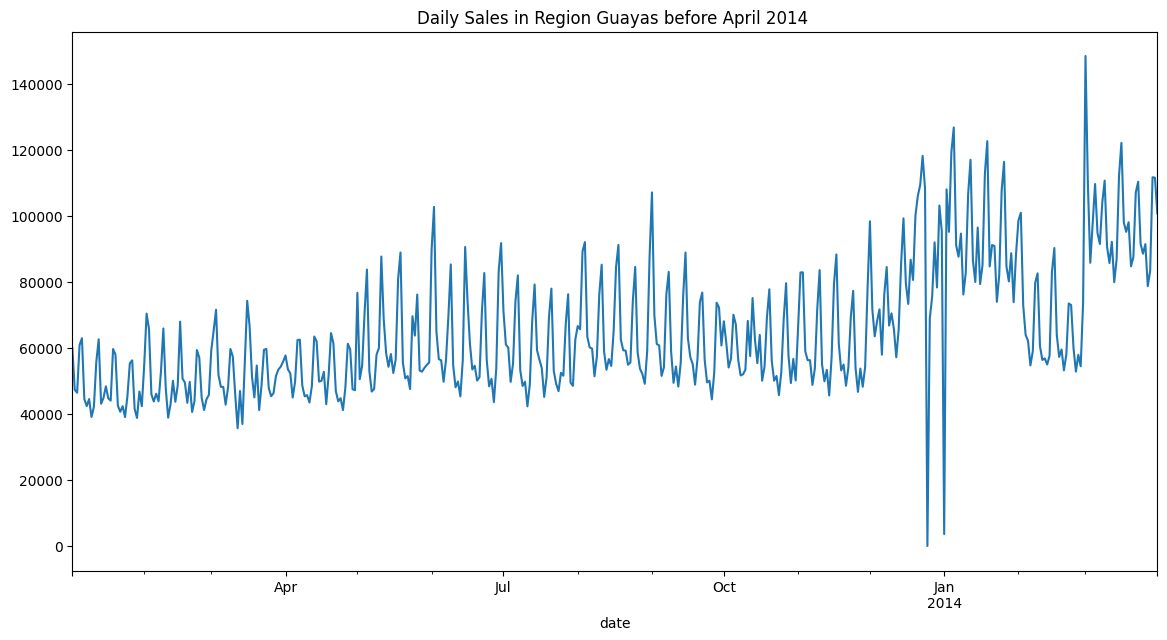

In [25]:
# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered['unit_sales'].plot()
plt.title('Daily Sales in Region Guayas before April 2014 ')
plt.show()

##Feature Engineering for Machine Learning

Lag Features

In [26]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered.dropna(inplace=True)

In [27]:
df_filtered

,unit_sales,lag_1,lag_7,lag_30
date,,,,
2013-02-01,54816.5200,42368.1060,45462.3970,59983.2120
2013-02-02,70444.1380,54816.5200,55370.0140,47337.7400
2013-02-03,65775.6290,70444.1380,56277.5480,46452.2430
2013-02-04,45994.1230,65775.6290,41593.8620,60858.1820
2013-02-05,43795.3320,45994.1230,38809.1660,62992.6320
...,...,...,...,...
2014-03-27,78761.4851,91495.9397,84784.0290,52860.6980
2014-03-28,83392.5058,78761.4851,87598.3547,57952.3090
2014-03-29,111751.7290,83392.5058,107191.4100,54475.7703


Rolling Statistics

In [28]:
# Create rolling mean and rolling standard deviation features
df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)


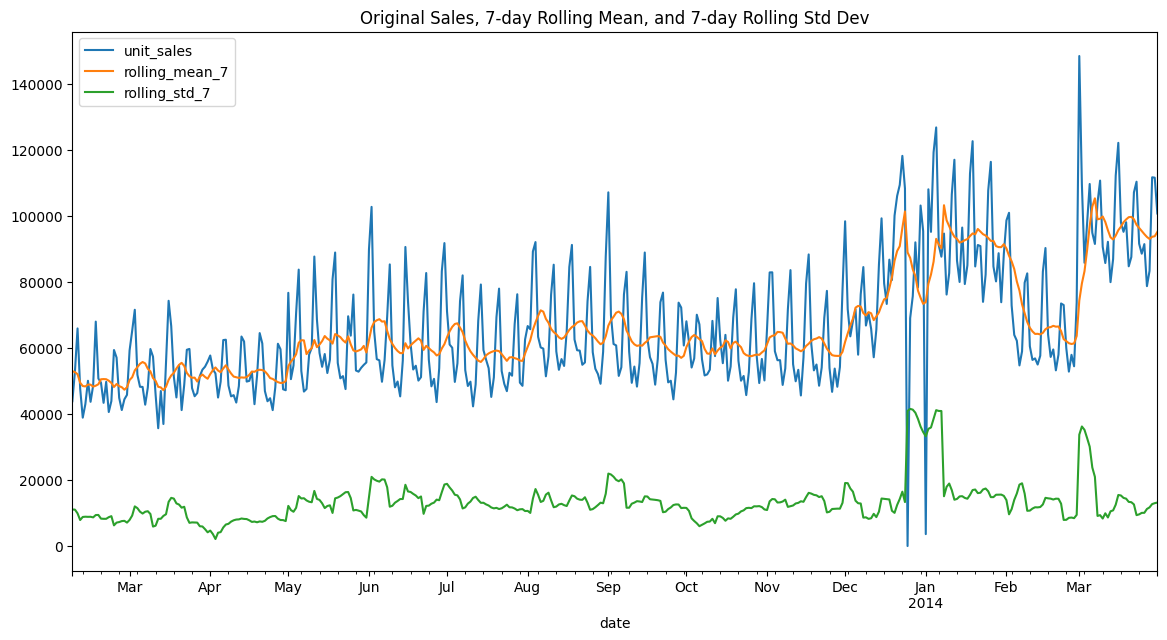

In [29]:
# Visualize the new features alongside the original sales
df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

Adding Date-based Features

In [30]:
# Add date-based features
df_filtered['day_of_week'] = df_filtered.index.dayofweek
df_filtered['month'] = df_filtered.index.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [31]:
df_filtered

,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_week,month,is_weekend
date,,,,,,,,,
2013-02-07,43885.0960,46169.1710,42368.1060,42393.4110,52982.858429,11063.169078,3,2,0
2013-02-08,52937.4870,43885.0960,54816.5200,44541.6950,52714.425143,11034.020188,4,2,0
2013-02-09,65944.4080,52937.4870,70444.1380,39108.1790,52071.606571,9901.976465,5,2,1
2013-02-10,47768.2450,65944.4080,65775.6290,42221.2530,49499.123143,7881.305102,6,2,1
2013-02-11,38909.5000,47768.2450,45994.1230,55798.1900,48487.034143,8806.954108,0,2,0
...,...,...,...,...,...,...,...,...,...
2014-03-27,78761.4851,91495.9397,84784.0290,52860.6980,93669.559986,11231.074262,3,3,0
2014-03-28,83392.5058,78761.4851,87598.3547,57952.3090,93068.724429,11712.197773,4,3,0
2014-03-29,111751.7290,83392.5058,107191.4100,54475.7703,93720.198571,12712.768793,5,3,1


###Splitting Data into Training and Testing Sets

In [32]:
# Define target variable (unit_sales) and features
X = df_filtered.drop('unit_sales', axis=1)
y = df_filtered['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

##XGBoost for Time-Series Forecasting

In [33]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

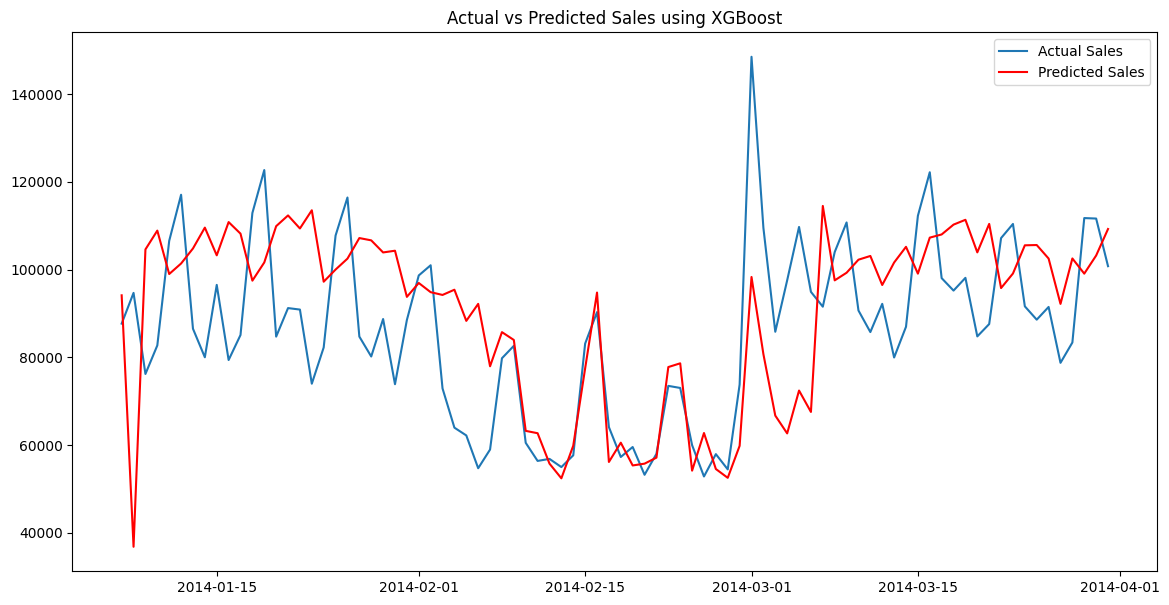

In [34]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [36]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 15645.18
Mean Squared Error (MSE): 375883107.90
Root Mean Squared Error (RMSE): 19387.71
R^2 Score: 0.03


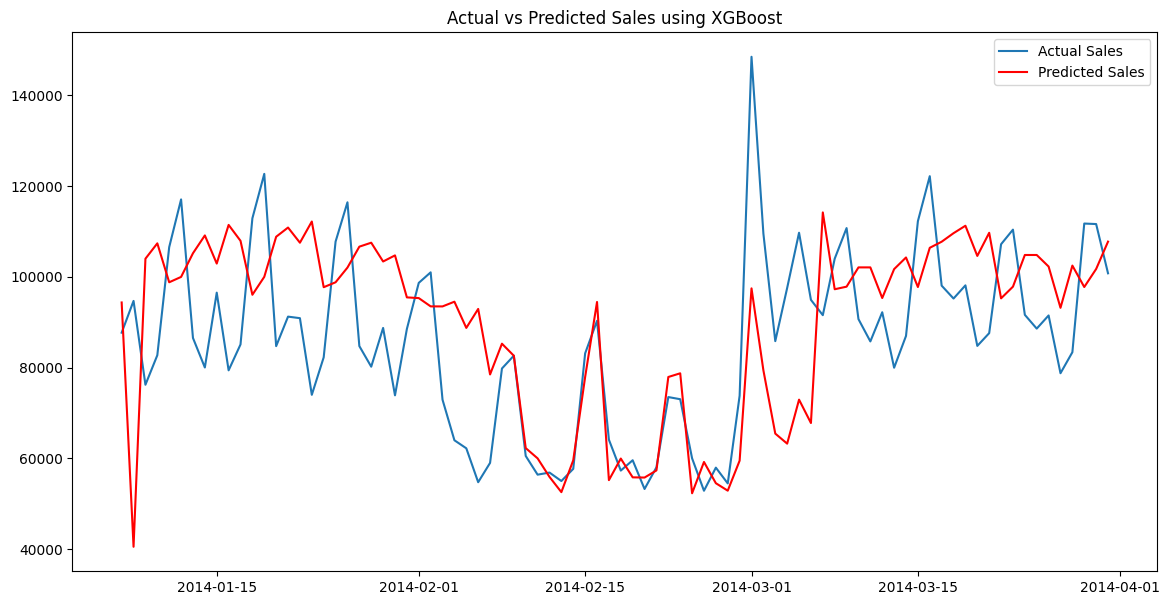

Mean Absolute Error (MAE): 15596.11
Mean Squared Error (MSE): 371391853.16
Root Mean Squared Error (RMSE): 19271.53
R^2 Score: 0.04


In [37]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

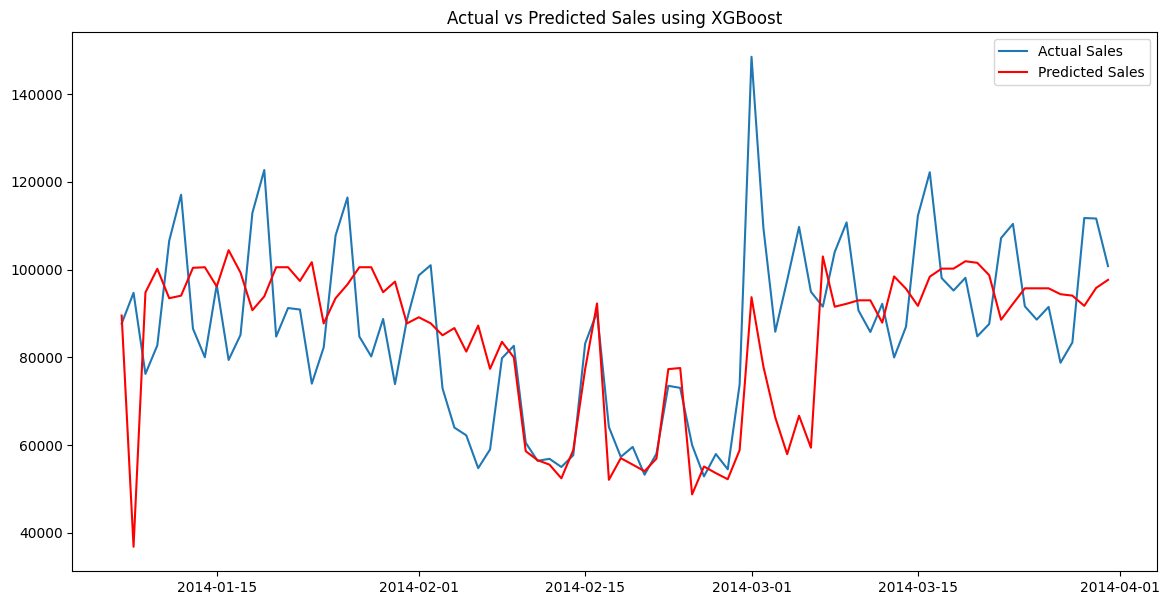

Mean Absolute Error (MAE): 13581.93
Mean Squared Error (MSE): 324218794.09
Root Mean Squared Error (RMSE): 18006.08
R^2 Score: 0.16


In [41]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

##Long Short-Term Memory Networks (LSTMs)

1)Data Preparation: First part was done for XGBoosting. Second part Preprocessing the Data for LSTM.

2)Building the LSTM Model:

3)Training the Model

4)Making Predictions

In [50]:
#Data Preparation- preprocessing step
# Normalize the data using Min-Max scaling

scaler = MinMaxScaler(feature_range=(0, 1))
df_filtered['unit_sales'] = scaler.fit_transform(df_filtered[['unit_sales']])

In [51]:
# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [52]:
# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filtered['unit_sales'].values
X, y = create_sequences(data, seq_length)

###Splitting Data into Training and Testing Sets

In [53]:
# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

###Building and Training the LSTM Model

####2 Layers

In [70]:
# Build the LSTM model
model = Sequential()
#first Layer
model.add(LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
#second Layer
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.1741 - val_loss: 0.1578
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0585 - val_loss: 0.0372
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0279 - val_loss: 0.0189
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0136 - val_loss: 0.0379
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0172 - val_loss: 0.0239
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0144 - val_loss: 0.0156
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0155 - val_loss: 0.0172
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0125 - val_loss: 0.0226
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0130 - val_loss: 0.0202
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0114 - val_loss: 0.0169
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0119 - val_loss: 0.0181
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0121 - val_lo

Making Predictions and Evaluating the Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


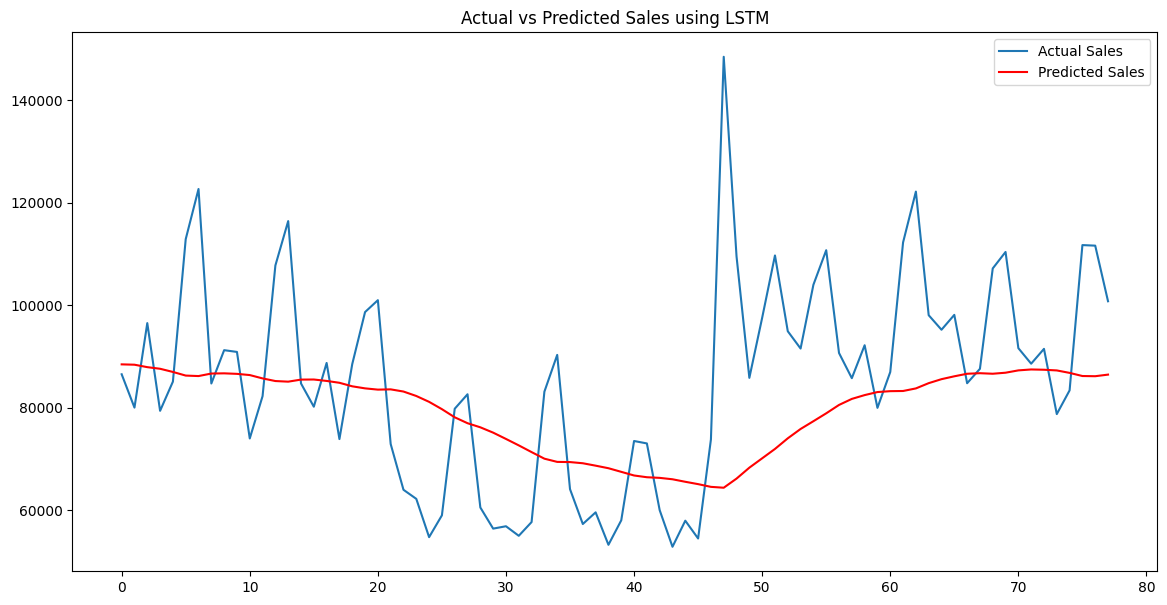

In [72]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

####3 Layers

In [73]:

# Build the LSTM model
model = Sequential()

# First Layer
model.add(LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))

# Second Layer (Newly added)
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Third Layer (Previously Second)
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - loss: 0.1642 - val_loss: 0.1280
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.0448 - val_loss: 0.0303
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0173 - val_loss: 0.0565
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.0259 - val_loss: 0.0375
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 0.0172 - val_loss: 0.0182
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0141 - val_loss: 0.0193
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0147 - val_loss: 0.0311
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.0123 - val_loss: 0.0230
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0107 - val_loss: 0.0230
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0115 - val_loss: 0.0216
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.0141 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step


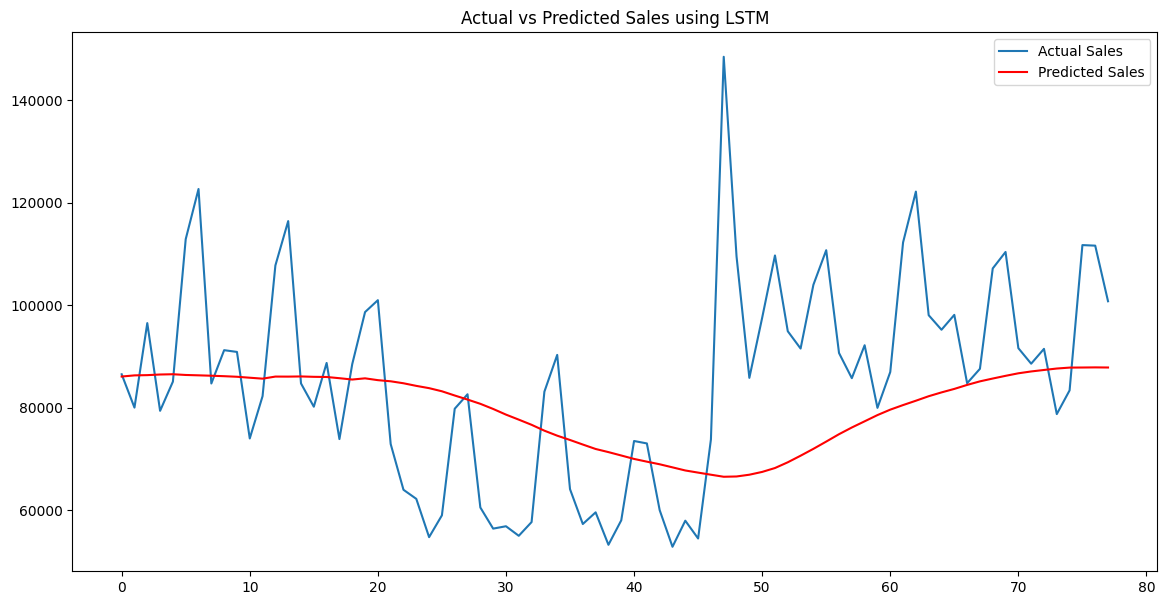

In [75]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

#### 4 Layers

In [76]:
# Build the LSTM model
model = Sequential()

# First LSTM Layer
model.add(LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM Layer
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM Layer
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 427ms/step - loss: 0.1865 - val_loss: 0.2283
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0829 - val_loss: 0.0409
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0346 - val_loss: 0.0543
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - loss: 0.0216 - val_loss: 0.0527
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.0174 - val_loss: 0.0205
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0167 - val_loss: 0.0248
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0131 - val_loss: 0.0453
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0153 - val_loss: 0.0302
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0140 - val_loss: 0.0220
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0149 - val_loss: 0.0323
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0134 - val_loss: 0.0331
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0149 - val_l

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


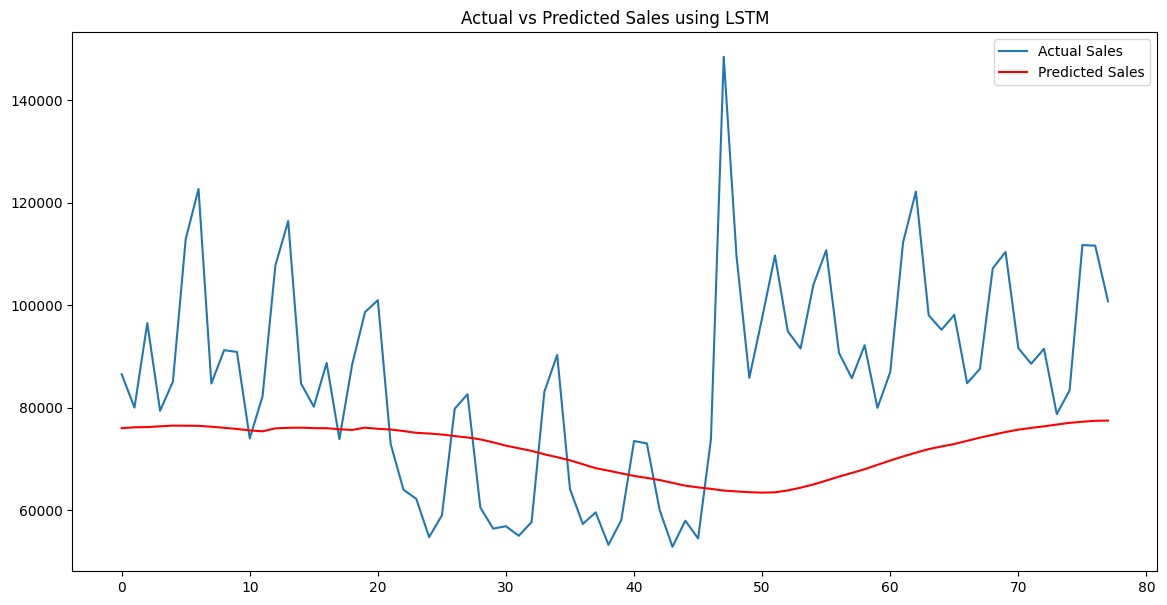

In [78]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

#### 3Layers+ dropout 0.3

In [80]:
from keras.layers import Bidirectional
model = Sequential()

# First Layer
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True)))
model.add(Dropout(0.3))

# Second Layer
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))

# Third Layer
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - loss: 0.1894 - val_loss: 0.1936
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0808 - val_loss: 0.0228
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0389 - val_loss: 0.0259
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.0259 - val_loss: 0.0563
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.0277 - val_loss: 0.0309
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.0192 - val_loss: 0.0158
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0242 - val_loss: 0.0192
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.0205 - val_loss: 0.0277
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0201 - val_loss: 0.0230
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.0145 - val_loss: 0.0194
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.0190 - val_l

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step


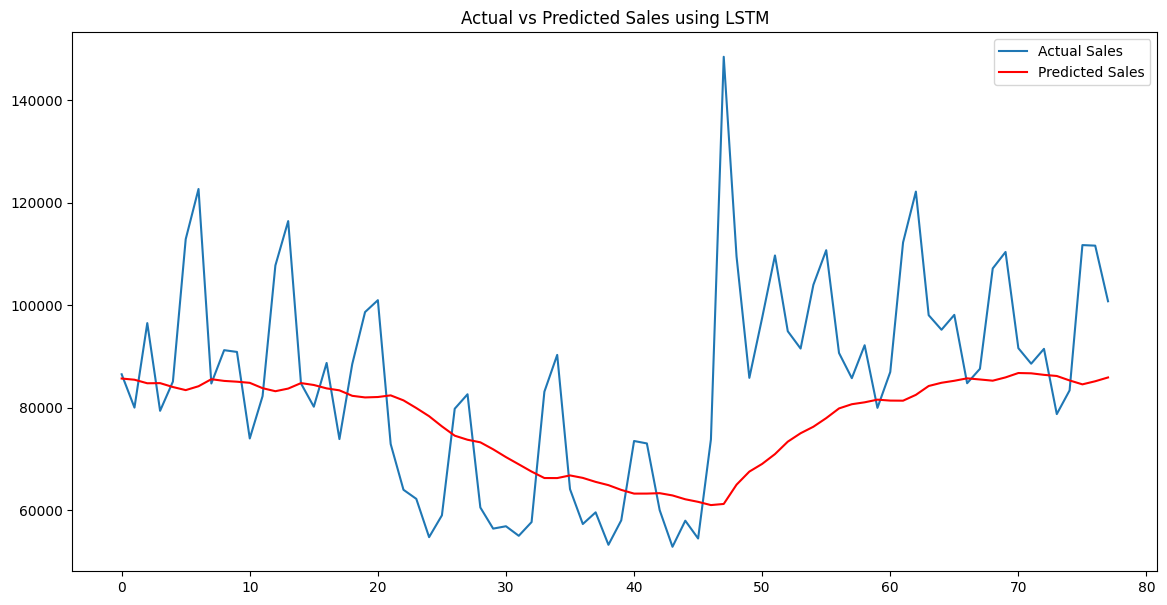

In [82]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()